In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from PIL import Image
import os
import torch
Path = './anime_faces/'
FILES = os.listdir(Path)
files = list()
labels = list()
w = 10000
l = 10000
for jdx in range(len(FILES)):
    file = torch.from_numpy(np.array((Image.open(Path + FILES[jdx])).resize((64, 64))))
    file = file.permute(2, 0, 1)
    w = file.shape[1] if file.shape[1] < w else w
    l = file.shape[2] if file.shape[2] < l else l
    files.append(file)
    print('\r{2}/{3}'.format(0, 0,jdx + 1, len(FILES)), end = '')

10000/10000

In [3]:
image = files[0].transpose(0, 2).transpose(0, 1)
N1 = image.shape[0]; N2 = image.shape[1]; N3 = image.shape[2]
images = image.reshape(1, N1, N2, N3)
for i in range(1, 100): #len(files)
    images = torch.cat((images, files[i].transpose(0, 2).transpose(0, 1).reshape(1, N1, N2, N3)), 0)
    print('\r{2}/{3}'.format(0, 0, i, len(files)), end = '')

99/10000

In [4]:
import matplotlib.pyplot as plt
images = images/255

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
graph_dim = 64*64
d1 = graph_dim//2
d2 = graph_dim//16
d3 = graph_dim//64
d4 = graph_dim//128
d_model = 2

In [7]:
class VariationalEncoder(nn.Module):
    def __init__(self):
        super(VariationalEncoder, self).__init__()
        self.Model1 = nn.Sequential(nn.Linear(graph_dim, d1),
                                    nn.ReLU(),
                                    nn.Linear(d1, d2),
                                    nn.ReLU(),
                                    nn.Linear(d2, d3),
                                    nn.ReLU())
        self.Model2 = nn.Sequential(nn.Linear(graph_dim, d1),
                                    nn.ReLU(),
                                    nn.Linear(d1, d2),
                                    nn.ReLU(),
                                    nn.Linear(d2, d3),
                                    nn.ReLU())
        self.Model3 = nn.Sequential(nn.Linear(graph_dim, d1),
                                    nn.ReLU(),
                                    nn.Linear(d1, d2),
                                    nn.ReLU(),
                                    nn.Linear(d2, d3),
                                    nn.ReLU())
        self.MU1 = nn.Linear(d3, d_model)
        self.SI1 = nn.Linear(d3, d_model)
        self.MU2 = nn.Linear(d3, d_model)
        self.SI2 = nn.Linear(d3, d_model)
        self.MU3 = nn.Linear(d3, d_model)
        self.SI3 = nn.Linear(d3, d_model)
        self.Distribution1 = torch.distributions.Normal(0, 1)
        self.Distribution2 = torch.distributions.Normal(0, 1)
        self.Distribution3 = torch.distributions.Normal(0, 1)

    def forward(self, x):
        X1, X2, X3 = torch.flatten(x[:,:,0], start_dim=1), torch.flatten(x[:,:,1], start_dim=1), torch.flatten(x[:,:,2], start_dim=1)
        X1, X2, X3 = self.Model1(X1), self.Model1(X2), self.Model1(X3)
        self.mu1, self.sigma1 = self.MU1(X1), self.SI1(X1)
        self.mu2, self.sigma2 = self.MU1(X2), self.SI1(X2)
        self.mu3, self.sigma3 = self.MU1(X3), self.SI1(X3)

        z1 = self.mu1 + self.sigma1*self.Distribution1.sample(self.mu1.shape)
        z2 = self.mu2 + self.sigma2*self.Distribution2.sample(self.mu2.shape)
        z3 = self.mu3 + self.sigma3*self.Distribution3.sample(self.mu3.shape)
        return z1, z2, z3

In [8]:
class VariationalDecoder(nn.Module):
    def __init__(self):
        super(VariationalDecoder, self).__init__()
        self.Model1 = nn.Sequential(nn.Linear(d_model, d3),
                                    nn.ReLU(),
                                    nn.Linear(d3, d2),
                                    nn.ReLU(),
                                    nn.Linear(d2, d1),
                                    nn.ReLU(),
                                    nn.Linear(d1, graph_dim),
                                    nn.Sigmoid())
        self.Model2 = nn.Sequential(nn.Linear(d_model, d3),
                                    nn.ReLU(),
                                    nn.Linear(d3, d2),
                                    nn.ReLU(),
                                    nn.Linear(d2, d1),
                                    nn.ReLU(),
                                    nn.Linear(d1, graph_dim),
                                    nn.Sigmoid())
        self.Model3 = nn.Sequential(nn.Linear(d_model, d3),
                                    nn.ReLU(),
                                    nn.Linear(d3, d2),
                                    nn.ReLU(),
                                    nn.Linear(d2, d1),
                                    nn.ReLU(),
                                    nn.Linear(d1, graph_dim),
                                    nn.Sigmoid())    
    def forward(self, x): # (N, 2)
        n = x[0].shape[0]
        X1, X2, X3 = self.Model1(x[0]).reshape(n, graph_dim, 1),self.Model2(x[1]).reshape(n, graph_dim, 1),self.Model3(x[2]).reshape(n, graph_dim, 1),
        X = torch.cat((X1, X2, X3), 2)
        return X

In [9]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder()
        self.decoder = VariationalDecoder()

    def forward(self, x):
        z = self.encoder(x)
        Result = self.decoder(z)
        return Result

In [10]:
X = images.reshape(images.shape[0], graph_dim, 3)

In [11]:
model = VariationalAutoencoder()
LOSS = nn.BCELoss(reduction = 'sum')
OPT = torch.optim.Adam(model.parameters(), lr = 0.001)
Losses = list()

In [12]:
BATCH = 16
for epoch in range(150):
    loss_val = 0
    for batch in range(0, X.shape[0], BATCH):
        if batch + BATCH > X.shape[0]:
            x = X[batch:]
        else:
            x = X[batch:batch + BATCH]
        OPT.zero_grad()
        output = model(x)
        BCE = LOSS(output, x)
        sigma1 = model.encoder.sigma1
        mu1 = model.encoder.mu1
        KL1 = - 0.5 * torch.sum(1 + sigma1 - mu1.pow(2) - torch.exp(sigma1))
        sigma2 = model.encoder.sigma2
        mu2 = model.encoder.mu2
        KL2 = - 0.5 * torch.sum(1 + sigma2 - mu2.pow(2) - torch.exp(sigma2))
        sigma3 = model.encoder.sigma3
        mu3 = model.encoder.mu3
        KL3 = - 0.5 * torch.sum(1 + sigma3 - mu3.pow(2) - torch.exp(sigma3))
        loss = BCE + KL1 + KL2 + KL3
        loss.backward()
        OPT.step()
        
    output = model(X)
    loss = LOSS(output, X)
    loss_val = float(loss)
    Losses.append(loss_val)
    print("Epoch: {0}; Loss: {1}".format(epoch + 1, loss_val))

Epoch: 1; Loss: 787472.875
Epoch: 2; Loss: 784666.1875
Epoch: 3; Loss: 754684.625
Epoch: 4; Loss: 755175.0
Epoch: 5; Loss: 742450.625
Epoch: 6; Loss: 746847.0625
Epoch: 7; Loss: 725277.0
Epoch: 8; Loss: 732373.375
Epoch: 9; Loss: 718736.9375
Epoch: 10; Loss: 731687.875
Epoch: 11; Loss: 716747.875
Epoch: 12; Loss: 733793.75
Epoch: 13; Loss: 717135.1875
Epoch: 14; Loss: 718953.25
Epoch: 15; Loss: 725192.3125
Epoch: 16; Loss: 721685.25
Epoch: 17; Loss: 728554.3125
Epoch: 18; Loss: 741529.25
Epoch: 19; Loss: 764836.6875
Epoch: 20; Loss: 727448.125
Epoch: 21; Loss: 736597.625
Epoch: 22; Loss: 720601.625
Epoch: 23; Loss: 715582.5
Epoch: 24; Loss: 713638.375
Epoch: 25; Loss: 710779.3125
Epoch: 26; Loss: 716398.75
Epoch: 27; Loss: 714146.0
Epoch: 28; Loss: 699782.9375
Epoch: 29; Loss: 698291.0
Epoch: 30; Loss: 697919.3125
Epoch: 31; Loss: 700581.875
Epoch: 32; Loss: 699859.0625
Epoch: 33; Loss: 694800.375
Epoch: 34; Loss: 693858.8125
Epoch: 35; Loss: 705541.5625
Epoch: 36; Loss: 702444.4375
Ep

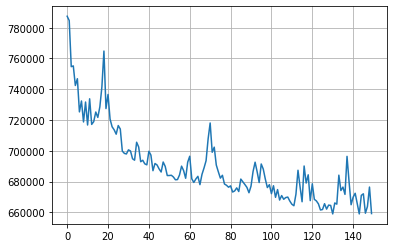

In [13]:
plt.plot(Losses)
plt.grid()
plt.show()

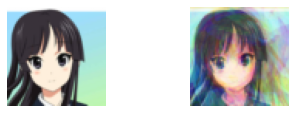

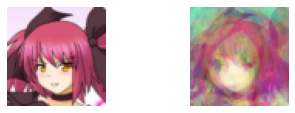

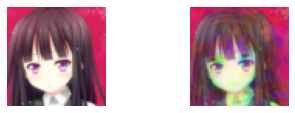

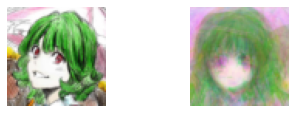

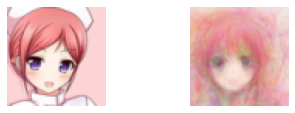

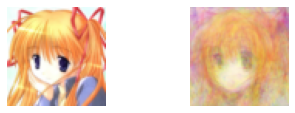

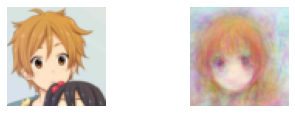

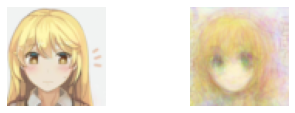

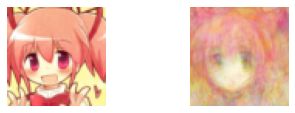

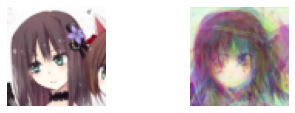

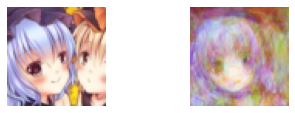

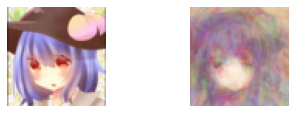

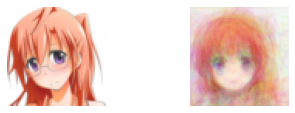

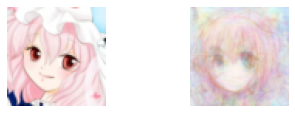

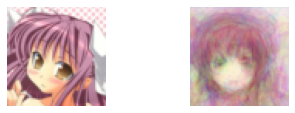

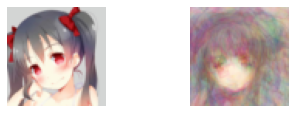

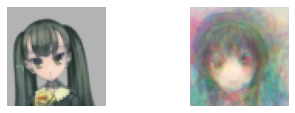

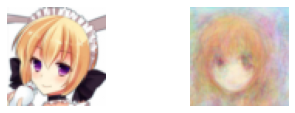

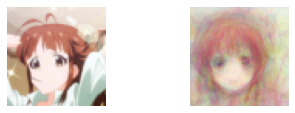

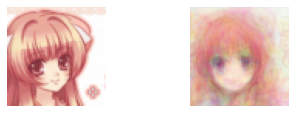

In [14]:
for i in range(20):
    Predict = (model(X[i].reshape(1, graph_dim, 3))[0]).reshape(64, 64, 3).detach().numpy()
    plt.subplot(2, 2, 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(Predict)
    plt.axis('off')
    plt.show()

In [ ]:
from scipy.stats import norm
grid_z1 = norm.ppf(np.linespace(0.05, 0.95, 5))
grid_z2 = norm.ppf(np.linespace(0.05, 0.95, 5))
grid_z3 = norm.ppf(np.linespace(0.05, 0.95, 5))
grid_z4 = norm.ppf(np.linespace(0.05, 0.95, 5))
grid_z5 = norm.ppf(np.linespace(0.05, 0.95, 5))
grid_z6 = norm.ppf(np.linespace(0.05, 0.95, 5))

In [56]:

grid_x = norm.ppf(np.linspace(0.05,0.95,6))#假設隱變量空間符合高斯分布
grid_y = norm.ppf(np.linspace(0.05,0.95,6))#ppf隨機取樣
k = 1
plt.figure(figsize = (10, 8))
for i,yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #重復z_sample多次，形成一個完整的batch
        z_sample = torch.tensor(np.tile(z_sample, 1).reshape(1, 2)).to(torch.float32)
        x_decoded = model.Decoder.forward(z_sample).reshape(64, 64).detach().numpy()
        plt.subplot(6, 6, k)
        plt.imshow(x_decoded, cmap='Greys_r')
        plt.axis('off')
        k += 1
plt.show()

AttributeError: 'VariationalAutoencoder' object has no attribute 'Decoder'

<Figure size 720x576 with 0 Axes>

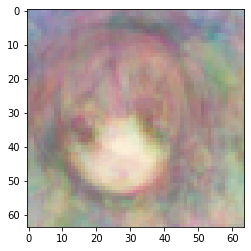

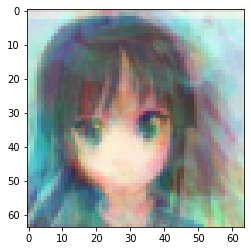

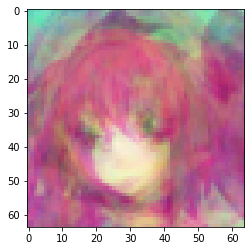

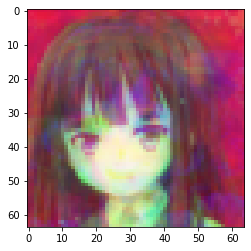

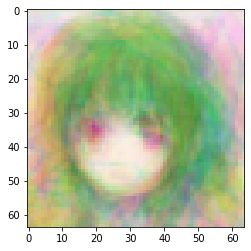

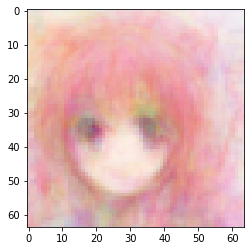

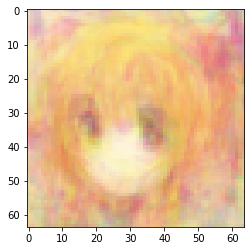

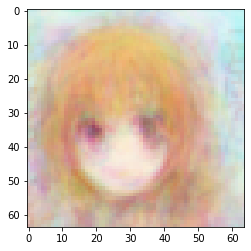

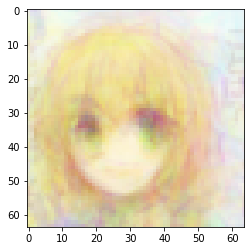

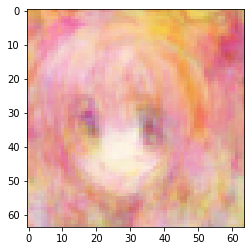

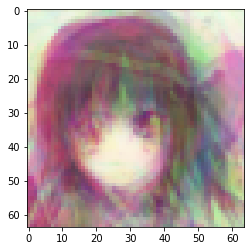

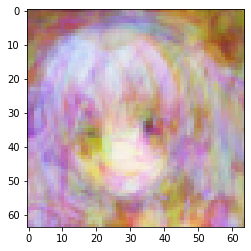

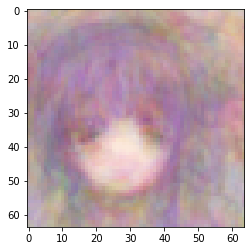

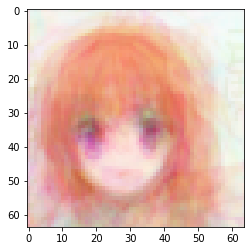

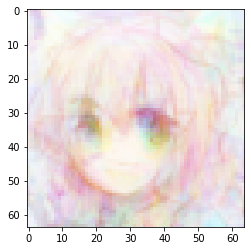

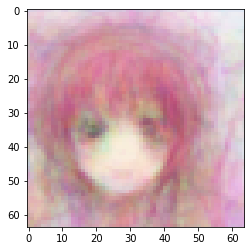

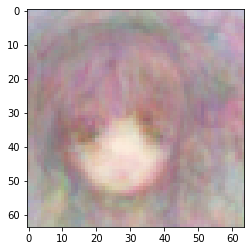

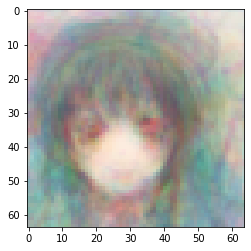

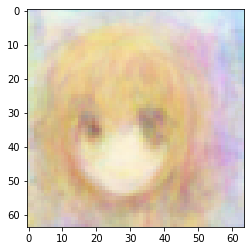

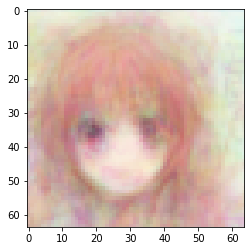

In [63]:
for i in range(20):
    Predict = (model(X[i].reshape(1, graph_dim, 3))[0]).reshape(64, 64, 3).detach().numpy()
    plt.imshow(Predict, cmap='Greys_r')
    plt.show()